# Titanic dataset

In this notebook, I practise the techniques for building a classification model. I will use the Titanic dataset to try and predict whether or not a passenger survives the disaster based on some features.

This dataset acn be found at https://www.kaggle.com/c/titanic

To begin with lets import the training and test sets and have a look at the training data. These are already split for us so we don't have to.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("datasets/titanic/train.csv")
test = pd.read_csv("datasets/titanic/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We see that there are 11 features and 1 class (survived). There are 891 instances. All the feature columns are full except for Age, Cabin and Embarked. Since the Age and Embarked attributes are almost full, we will try to fill them in using some of the other features (try to find some correlations or use the mean values) Since the cabin feature is only about 25% full, we will drop this feature for now.

Now lets separate the training data into the features and labels:

In [4]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

In [5]:
X_train.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


The categories for sex and Embarked will need to be encoded, using binary encoding for Sex (0 for male, 1 for female) and one-hot-encoding for Embarked. Also, passenger ID is not an attribute we want to train the data on, so we will drop this attribute as well as cabin. Since the Ticket number is also seeminly random and unstructured, we will drop this column also.

So the final dataset has the attributes:

PClass, Sex, Age, SibSp, Parch, Fare, Embarked

In [6]:
X_train_reduced = X_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
X_train_reduced.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


Lets create a class to select the attributes we want so we can put it into a pipeline for the test set. We will also drop any instances with NaN values in the categorical data columns (Sex and Embarked):

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

X_attr = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
y_attr = ['Survived']

class AttributeSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes):
        self.attributes = attributes
        
    def fit(self):
        return self
    
    def transform(self, X, y=None):
        return X[self.attributes]
    
    def fit_transform(self, X, y=None):
        return X[self.attributes]
    

train.dropna(subset=['Sex', 'Embarked'], inplace=True)
train.info()

attrib_select_X = AttributeSelector(X_attr)
attrib_select_y = AttributeSelector(y_attr)

X_train = attrib_select_X.transform(train)
y_train = attrib_select_y.transform(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
Pclass      889 non-null int64
Sex         889 non-null object
Age         712 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 55.6+ KB


Now we need to deal with missing values. For the age, we will simply use the mean value:

In [9]:
from sklearn.preprocessing import Imputer, StandardScaler

num_attributes = X_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
imputer = Imputer(strategy="mean")

num_attributes = imputer.fit_transform(num_attributes)

scaler = StandardScaler()

num_attributes = scaler.fit_transform(num_attributes)

We also need to encode the categorical data:

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

sex = X_train['Sex'].values
sex_encoder = LabelEncoder()
sex_encoded = sex_encoder.fit_transform(sex)

embarked = X_train['Embarked'].values
embarked_encoder = LabelEncoder()
embarked_encoded = embarked_encoder.fit_transform(embarked)

onehot = OneHotEncoder(sparse=False)
embarked_encoded = onehot.fit_transform(embarked_encoded.reshape(-1, 1))[:, :-1]
# I dropped one of the embarked columns since one of the classes is a dummy variable.

In [11]:
embarked_encoded

array([[0., 0.],
       [1., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [1., 0.],
       [0., 1.]])

In [12]:
X_train_clean = np.c_[num_attributes, sex_encoded, embarked_encoded]
X_train_clean[0, :]

array([ 0.82520863, -0.58961986,  0.43135024, -0.47432585, -0.50023975,
        1.        ,  0.        ,  0.        ])

In [13]:
print(X_train_clean.shape, y_train.shape)

(889, 8) (889, 1)


Ok, now the trainnig data is all prepared. We can now start to choose our models. This is a binary classification task. The models I will investigate are:

1. SGDClassifier
2. RandomForestClassifier

I will use the precision, reacll and accuracy to evaluate each model and to tune the hyperparameters. 

To begin with, I will combine all the data prep stages into a single pipeline so preparing the test set will be easy.

#### Pipeline

In [14]:
from sklearn.pipeline import Pipeline, FeatureUnion

num_attr = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
sex_attr = ['Sex']
emb_attr = ['Embarked']

# Create a transformer to drop instances of NaN
class DropInstance(BaseEstimator, TransformerMixin):
    
    def transform(self, X, attributes, y=None):
        return X.dropna(subset=attributes)
    
    def fit_transform(self, X, attributes, y=None):
        return X.dropna(subset=attributes)
    

# Modified label encoder to feed into onehot encoder
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y.values.ravel()).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y.values.ravel()).reshape(-1, 1)
    

# Modified onehot encoder to delete dummy variable
class ModifiedOneHot(OneHotEncoder):
    
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y)[:, :-1]

    def transform(self, y, *args, **kwargs):
        return super().transform(y)[:, :-1]

    
num_pipeline = Pipeline([
    ('Selector', AttributeSelector(num_attr)),
    ('imputer', Imputer(strategy="mean")),
    ('scaler', StandardScaler()),
])

sex_pipeline = Pipeline([
    ('Selector', AttributeSelector(sex_attr)),
    ('encoder', ModifiedLabelEncoder()),
])

emb_pipeline = Pipeline([
    ('Selector', AttributeSelector(emb_attr)),
    ('encoder', ModifiedLabelEncoder()),
    ('onehotencoder', ModifiedOneHot(sparse=False)),
])

full_pipeline_X = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('sex_pipeline', sex_pipeline),
    ('emb_piepline', emb_pipeline),
])

titanic_prepared = full_pipeline_X.fit_transform(X_train)

#### SGDClassifier:

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

sgd_clf = SGDClassifier(max_iter=5, tol=None)

scores = cross_val_score(sgd_clf, titanic_prepared, y_train.values.ravel(), cv=3, scoring='accuracy')

In [29]:
scores

array([0.69360269, 0.71959459, 0.67567568])

For starters, these accuracy scores are quite low. Lets look at the confusion matrix:

In [36]:
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(sgd_clf, titanic_prepared, y_train.values.ravel(), cv=3)

sgd_conf = confusion_matrix(y_train, y_pred)
sgd_conf

array([[410, 139],
       [112, 228]], dtype=int64)

Lets also look at the precision and recall scores:

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: ',
      precision_score(y_train, y_pred),
      '\nRecall: ',
      recall_score(y_train, y_pred),
      '\nF1 Score: ',
      f1_score(y_train, y_pred)
     )

Precision:  0.6212534059945504 
Recall:  0.6705882352941176 
F1 Score:  0.6449787835926449


These are similarly bad. This indicates that the linear classifier is perhaps not suited to this data set. Lets use a random forest instead.

#### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10)

scores_forest = cross_val_score(forest_clf, titanic_prepared, y_train.values.ravel(), cv=3, scoring='accuracy')
scores_forest

array([0.76430976, 0.78040541, 0.78378378])

In [64]:
y_pred_forest = cross_val_predict(forest_clf, titanic_prepared, y_train.values.ravel(), cv=3)

print('Precision: ',
      precision_score(y_train, y_pred_forest),
      '\nRecall: ',
      recall_score(y_train, y_pred_forest),
      '\nF1 Score: ',
      f1_score(y_train, y_pred_forest)
     )

Precision:  0.7639344262295082 
Recall:  0.6852941176470588 
F1 Score:  0.7224806201550387


In [65]:
forest_conf = confusion_matrix(y_train, y_pred_forest)
forest_conf

array([[477,  72],
       [107, 233]], dtype=int64)

This model performs significantly better than the SGDClassifier. The recall is approximately the same however. THis means that the model got better at recognising non-survivor but not better at recognising survivors. Overall, there is improvement. Lets now try to tune the hyperparameters:

In [66]:
from sklearn.model_selection import GridSearchCV

params = [
    {'n_estimators': [10, 20, 30, 40, 50], 'max_features': [2, 4, 6, 8]},
]
grid_search = GridSearchCV(forest_clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(titanic_prepared, y_train.values.ravel())

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50], 'max_features': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [67]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8835453686414151 {'max_features': 2, 'n_estimators': 10}
0.886087950498142 {'max_features': 2, 'n_estimators': 20}
0.8917822551223932 {'max_features': 2, 'n_estimators': 30}
0.8917822551223932 {'max_features': 2, 'n_estimators': 40}
0.8911513514317336 {'max_features': 2, 'n_estimators': 50}
0.8898882021767978 {'max_features': 4, 'n_estimators': 10}
0.9005684993642872 {'max_features': 4, 'n_estimators': 20}
0.894301419053713 {'max_features': 4, 'n_estimators': 30}
0.8955583436642398 {'max_features': 4, 'n_estimators': 40}
0.8930427253700312 {'max_features': 4, 'n_estimators': 50}
0.8968135066399192 {'max_features': 6, 'n_estimators': 10}
0.8930427253700312 {'max_features': 6, 'n_estimators': 20}
0.894301419053713 {'max_features': 6, 'n_estimators': 30}
0.894301419053713 {'max_features': 6, 'n_estimators': 40}
0.8930427253700312 {'max_features': 6, 'n_estimators': 50}
0.8911513514317336 {'max_features': 8, 'n_estimators': 10}
0.890520000766984 {'max_features': 8, 'n_estimators': 20}
0.

In [71]:
best_forest = grid_search.best_estimator_
best_forest.feature_importances_

array([0.07977406, 0.25918647, 0.04991073, 0.02922823, 0.27318708,
       0.27707294, 0.02048972, 0.01115077])

In [73]:
attributes = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked1', 'Embarked2']

sorted(zip(best_forest.feature_importances_, attributes), reverse=True)

[(0.2770729393478822, 'Sex'),
 (0.2731870816971812, 'Fare'),
 (0.2591864705258983, 'Age'),
 (0.0797740647656712, 'Pclass'),
 (0.04991072967527385, 'SibSp'),
 (0.02922822776057791, 'Parch'),
 (0.020489719214641176, 'Embarked1'),
 (0.0111507670128742, 'Embarked2')]

The most important attributes to the model are Sex, Fare (probably related to wealth and cabin location) and Age. Certainly, where they embarked from is not at all important. Because of this I will drop Embarked, Parch and SibSp from the dataset and train the model on this. 

In [76]:
important_num_attr = ['Pclass', 'Age', 'Fare']

num_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(important_num_attr)),
    ('imputer', Imputer(strategy="mean")),
    ('scaler', StandardScaler()),
])

sex_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(sex_attr)),
    ('encoder', ModifiedLabelEncoder()),
])

new_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_new),
    ('sex_pipeline', sex_pipeline_new),
])

titanic_prepared_new = new_pipeline.fit_transform(X_train)

In [95]:
forest_clf = RandomForestClassifier()
params = [
    {'n_estimators': [30, 32, 34, 36, 38, 40], 'max_features': [2, 4]},
]
grid_search = GridSearchCV(forest_clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(titanic_prepared_new, y_train.values.ravel())

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [30, 32, 34, 36, 38, 40], 'max_features': [2, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [96]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.8936722938129552 {'max_features': 2, 'n_estimators': 30}
0.8949301020270023 {'max_features': 2, 'n_estimators': 32}
0.8968135066399192 {'max_features': 2, 'n_estimators': 34}
0.898066915367079 {'max_features': 2, 'n_estimators': 36}
0.8955583436642398 {'max_features': 2, 'n_estimators': 38}
0.8949301020270023 {'max_features': 2, 'n_estimators': 40}
0.8848175728549054 {'max_features': 4, 'n_estimators': 30}
0.894301419053713 {'max_features': 4, 'n_estimators': 32}
0.8968135066399192 {'max_features': 4, 'n_estimators': 34}
0.8911513514317336 {'max_features': 4, 'n_estimators': 36}
0.890520000766984 {'max_features': 4, 'n_estimators': 38}
0.8911513514317336 {'max_features': 4, 'n_estimators': 40}


In [97]:
forest_new = grid_search.best_estimator_

So removing these features made no difference to the accuracy, as expected. We can now evaluate this model on the test set. First we need to pass the test set through the data prep stage.

In [98]:
X_test_prepared = new_pipeline.transform(test)

In [100]:
test_pred = forest_new.predict(X_test_prepared)

To see if the model predicted correctly, we need to import the results into Kaggle.

In [110]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = test_pred

In [115]:
submission.to_csv('datasets/titanic/submission.csv', index_label=False, index=False)

This submission scored 72.7% on the Kaggle leaderboard. This is not bad but could be much better, considering some submissions have 100% accuracy (but maybe these know something I don't). For the purpose of this practise, I think it was helpful.

The main thing I have learned from this dataset is how much of a pain missing values can be.

In [116]:
train['Survived'].value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [118]:
print(549/(549+340))

0.6175478065241845


We can see that even if you just assume everyone dies, the accuracy is still 62%, so we have only improved from this accuracy by about 10%. In fact, by predicting that all men die and all women survive acually gets you a score of 78% so my model is even worse.

In [122]:
submission2 = pd.DataFrame()
submission2['PassengerId'] = test['PassengerId']
submission2['Survived'] = np.zeros((418,))
submission2.to_csv('datasets/titanic/submission2.csv', index_label=False, index=False)

In [138]:
y = (X_test_prepared[:, -1].astype(int) != 1)

In [142]:
y = y.astype(int)

In [143]:
submission3 = pd.DataFrame()
submission3['PassengerId'] = test['PassengerId']
submission3['Survived'] = y
submission3.to_csv('datasets/titanic/submission3.csv', index_label=False, index=False)

By letting all men die and women survive, my model is actualy better than the random forest model. So we know that Sex is a strong influence on wether someone lives or not. The next most important feature was Fare.

In [149]:
important_num_attr = ['Age']

num_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(important_num_attr)),
    ('imputer', Imputer(strategy="mean")),
    ('scaler', StandardScaler()),
])

sex_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(sex_attr)),
    ('encoder', ModifiedLabelEncoder()),
])

new_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_new),
    ('sex_pipeline', sex_pipeline_new),
])

titanic_prepared_new = sex_pipeline_new.fit_transform(X_train)

forest_clf = RandomForestClassifier()
params = [
    {'n_estimators': [30, 32, 34, 36, 38, 40]},
]
grid_search = GridSearchCV(forest_clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(titanic_prepared_new, y_train.values.ravel())

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [30, 32, 34, 36, 38, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [151]:
X_test_new = sex_pipeline_new.transform(test)

y2 = grid_search.best_estimator_.predict(X_test_new)

submission4 = pd.DataFrame()
submission4['PassengerId'] = test['PassengerId']
submission4['Survived'] = y2
submission4.to_csv('datasets/titanic/submission4.csv', index_label=False, index=False)

Whenever I add a attribute as well as Sex, the score decreases. I need to perform some feature engineering to come up with a more representable feature.

Perhaps we can look at the fare and deduce the social status of the passenger. Or classifiy the passenger as child, adult and senior to make a general age attribute.

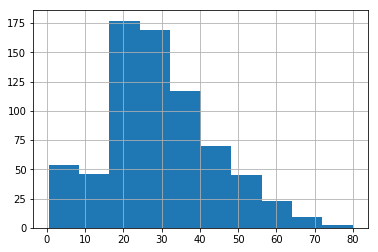

In [152]:
train['Age'].hist()

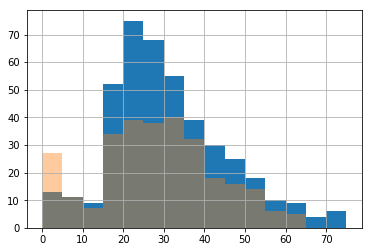

In [161]:
bins = np.arange(0, 80, 5)

train.loc[train['Survived'] == 0]['Age'].hist(bins=bins)
train.loc[train['Survived'] == 1]['Age'].hist(alpha=0.4, bins=bins)

What this histogram shows is the number of passengers in different age groups that survived (orange) and died (blue). What we see is that for under 10s, the majority survived. ie, for infants. However, for the others, the majority died. Especially in the middle section (15-40). I will now cetegorise the ages into these 3 groups.

In [169]:
infants = (train['Age'] < 10).astype(int)
adults = (train['Age'] <= 40).astype(int)
seniors = (train['Age'] <= 100).astype(int)

In [170]:
age_cat = infants + adults + seniors

In [174]:
train['Age Cat'] = age_cat
y_train = train['Survived'].values.ravel()

In [178]:
important_num_attr = ['Age Cat']

num_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(important_num_attr)),
])

sex_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(sex_attr)),
    ('encoder', ModifiedLabelEncoder()),
])

new_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_new),
    ('sex_pipeline', sex_pipeline_new),
])

titanic_prepared_new = new_pipeline.fit_transform(train)

forest_clf = RandomForestClassifier()
params = [
    {'n_estimators': [10, 20, 30, 40]},
]
grid_search = GridSearchCV(forest_clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(titanic_prepared_new, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [179]:
infants = (test['Age'] < 10).astype(int)
adults = (test['Age'] <= 40).astype(int)
seniors = (test['Age'] <= 100).astype(int)
test['Age Cat'] = infants + adults + seniors

X_test_new = new_pipeline.transform(test)

y2 = grid_search.best_estimator_.predict(X_test_new)

submission5 = pd.DataFrame()
submission5['PassengerId'] = test['PassengerId']
submission5['Survived'] = y2
submission5.to_csv('datasets/titanic/submission5.csv', index_label=False, index=False)

this slightly improved the model! Lets do the same thing for Fare:

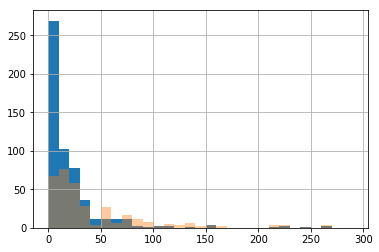

In [184]:
bins = np.arange(0, 300, 10)

train.loc[train['Survived'] == 0]['Fare'].hist(bins=bins)
train.loc[train['Survived'] == 1]['Fare'].hist(alpha=0.4, bins=bins)

Here we can also see that the lower fare people tended to die, while the mojority of high fare passengers survived. Lets make categories for these ones aswell. I will have two categories for this, rich and poor (<$50 fare).

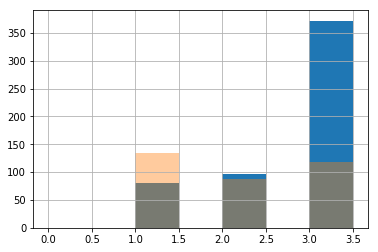

In [192]:
bins = np.arange(0, 4, 0.5)

train.loc[train['Survived'] == 0]['Pclass'].hist(bins=bins)
train.loc[train['Survived'] == 1]['Pclass'].hist(alpha=0.4, bins=bins)

Here we also see that Pclass gives a good indication of death or not. THe 3rd class passengers are extremely likely to die, while 1st class a more likely to survive.

In [193]:
train['Fare cat'] = (train['Fare'] < 50).astype(int)

In [194]:
important_num_attr = ['Age Cat', 'Fare cat', 'Pclass']

num_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(important_num_attr)),
])

sex_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(sex_attr)),
    ('encoder', ModifiedLabelEncoder()),
])

new_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_new),
    ('sex_pipeline', sex_pipeline_new),
])

titanic_prepared_new = new_pipeline.fit_transform(train)

forest_clf = RandomForestClassifier()
params = [
    {'n_estimators': [10, 20, 30, 40]},
]
grid_search = GridSearchCV(forest_clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(titanic_prepared_new, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [195]:
test['Fare cat'] = (test['Fare'] < 50).astype(int)

X_test_new = new_pipeline.transform(test)

y2 = grid_search.best_estimator_.predict(X_test_new)

submission6 = pd.DataFrame()
submission6['PassengerId'] = test['PassengerId']
submission6['Survived'] = y2
submission6.to_csv('datasets/titanic/submission6.csv', index_label=False, index=False)

In [196]:
grid_search.best_estimator_.feature_importances_

array([0.13483391, 0.06812768, 0.21891971, 0.57811871])

The score actually went down! According to the feature importances, the Pclass and Sex are the most important.

In [197]:
important_num_attr = ['Pclass']

num_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(important_num_attr)),
])

sex_pipeline_new = Pipeline([
    ('Selector', AttributeSelector(sex_attr)),
    ('encoder', ModifiedLabelEncoder()),
])

new_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline_new),
    ('sex_pipeline', sex_pipeline_new),
])

titanic_prepared_new = new_pipeline.fit_transform(train)

forest_clf = RandomForestClassifier()
params = [
    {'n_estimators': [10, 20, 30, 40]},
]
grid_search = GridSearchCV(forest_clf, param_grid=params, cv=3, scoring='accuracy')
grid_search.fit(titanic_prepared_new, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [198]:
X_test_new = new_pipeline.transform(test)

y2 = grid_search.best_estimator_.predict(X_test_new)

submission6 = pd.DataFrame()
submission6['PassengerId'] = test['PassengerId']
submission6['Survived'] = y2
submission6.to_csv('datasets/titanic/submission6.csv', index_label=False, index=False)